Outline：
1. Read data to df
2. Fill in null value
3. Encode intake_type, intake_condition, animal type, sex_upon_intake, breed, pure_color, outcome_type, sex_upon_outcome to ordinal
4. Split data into train and test
5. Choose model for training
6. Predict test dataset and evaluate result 

In [ ]:
# Imports for later use
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
# from sklearn.preprocessing import OneHotEncode
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import collections
from google.colab import drive
import seaborn as sns
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import json

In [ ]:
df = pd.read_csv('Austin_Animal_Center_Cleaned.csv')
df.head()

,animal_id,name,intake_datetime,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,color,outcome_datetime,date_of_birth,outcome_type,outcome_subtype,sex_upon_outcome,age_upon_outcome,has_name,age_upon_intake_day,age_upon_outcome_day,birth_sex,pure_color,sex_changed,intake_times
0,A006100,Scamp,2014-03-07 14:26:00,8700 Research in Austin (TX),Public Assist,Normal,Dog,Neutered Male,6 years,Spinone Italiano Mix,Yellow/White,2014-03-08 17:10:00,2007-07-09 00:00:00,Return to Owner,NaN,Neutered Male,6 years,1.0,2433.0,2434.0,Male,0,1.0,1
1,A006100,Scamp,2014-12-19 10:21:00,8700 Research Blvd in Austin (TX),Public Assist,Normal,Dog,Neutered Male,7 years,Spinone Italiano Mix,Yellow/White,2014-12-20 16:35:00,2007-07-09 00:00:00,Return to Owner,NaN,Neutered Male,7 years,1.0,2720.0,2721.0,Male,0,1.0,2
2,A006100,Scamp,2017-12-07 14:07:00,Colony Creek And Hunters Trace in Austin (TX),Stray,Normal,Dog,Neutered Male,10 years,Spinone Italiano Mix,Yellow/White,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,Male,0,NaN,3
3,A047759,Oreo,2014-04-02 15:55:00,Austin (TX),Owner Surrender,Normal,Dog,Neutered Male,10 years,Dachshund,Tricolor,2014-04-07 15:12:00,2004-04-02 00:00:00,Transfer,Partner,Neutered Male,10 years,1.0,3652.0,3657.0,Male,0,1.0,1
4,A134067,Bandit,2013-11-16 09:02:00,12034 Research Blvd in Austin (TX),Public Assist,Injured,Dog,Neutered Male,16 years,Shetland Sheepdog,Brown/White,2013-11-16 11:54:00,1997-10-16 00:00:00,Return to Owner,NaN,Neutered Male,16 years,1.0,5875.0,5875.0,Male,0,1.0,1


In [ ]:
#drive.mount('/content/drive')

# Feature engineering

In [ ]:
# Create data
data = df.loc[:, ['intake_type', 'intake_condition', 'animal_type', 
           'birth_sex', 'sex_changed', 'breed', 'has_name', 
           'age_upon_outcome_day', 'pure_color', 'intake_times']]
# split sex into two features: male or not, female or not
data['male_or_not'] = np.where(data['birth_sex']=="Male", 1, 0)
data['female_or_not'] = np.where(data['birth_sex']=="Female", 1, 0)
data = data.drop(columns="birth_sex")
# add a feature "multi-intake"
data['multi-intake'] = np.where(data['intake_times']==1, 0, 1)
data = data.drop(columns='intake_times')
# Replace null value
# data.loc[data['birth_sex'].isnull(), 'birth_sex'] = 'NA'
data.loc[data['sex_changed'].isnull(), 'sex_changed'] = 0 # regard unknown as no change
data.loc[data['age_upon_outcome_day'].isnull(), 'age_upon_outcome_day'] = -1


# Encode categorical data to numerical
label_encoder = preprocessing.LabelEncoder()
data.loc[:, 'intake_type'] = label_encoder.fit_transform(data['intake_type'])
# intake_type = list(label_encoder.classes_)
a_file = open("intake_type.pkl", "wb")
pickle.dump(label_encoder, a_file)
a_file.close()

data.loc[:, 'intake_condition'] = label_encoder.fit_transform(data['intake_condition'])
# intake_condition = list(label_encoder.classes_)
b_file = open("intake_condition.pkl", "wb")
pickle.dump(label_encoder, b_file)
b_file.close()

data.loc[:, 'animal_type'] = label_encoder.fit_transform(data['animal_type'])
# animal_type = list(label_encoder.classes_)
c_file = open("animal_type.pkl", "wb")
pickle.dump(label_encoder, c_file)
c_file.close()

# sex_upon_intake = list(label_encoder.classes_)
# data.loc[:, 'birth_sex'] = label_encoder.fit_transform(data['birth_sex'])
# birth_sex = list(label_encoder.classes_)
data.loc[:, 'breed'] = label_encoder.fit_transform(data['breed'])
# breed = list(label_encoder.classes_)
d_file = open("breed.pkl", "wb")
pickle.dump(label_encoder, d_file)
d_file.close()

# Onehotlabel = OneHotEncoder(sparse=False)
# label.loc[:, 'outcome_type'] = label_encoder.fit_transform(label['outcome_type'])
# outcome_type = list(label_encoder.classes_)
# label.loc[:, 'outcome_type'] = Onehotlabel.fit_transform(np.array(label['outcome_type'].values.tolist()).reshape(-1, 1))
# outcome_type = list(Onehotlabel.categories_)
# label.loc[:, 'outcome_subtype'] = label_encoder.fit_transform(label['outcome_subtype'])
# outcome_subtype = list(label_encoder.classes_)

# labels are adoption(1) or non-adoption(0)
label = df.loc[:, ['outcome_type']]

# Not consider the subtype
# label.loc[:, 'outcome_type'] = label['outcome_type'] + ' ' +  label['outcome_subtype']
# label = label.drop(columns='outcome_subtype')
label.loc[label['outcome_type'].isnull(), 'outcome_type'] = 'Current in shelter'
# label.loc[label['outcome_subtype'].isnull(), 'outcome_subtype'] = ''
label['adoption'] = np.where(label['outcome_type']=='Adoption', 0, 1)
label = label.drop(columns='outcome_type')


In [ ]:
label_encoder.classes_

array(['Abyssinian', 'Abyssinian Mix', 'Affenpinscher', ...,
       'Yorkshire Terrier/Standard Poodle',
       'Yorkshire Terrier/Toy Poodle',
       'Yorkshire Terrier/Yorkshire Terrier'], dtype=object)

In [ ]:
### Save encoder for categorical class
# intake_type = dict.fromkeys(intake_type, 0)
# intake_condition = dict.fromkeys(intake_condition, 0)
# animal_type = dict.fromkeys(animal_type, 0)
# breed = dict.fromkeys(breed, 0)
# a_file = open("intake_type.pkl", "wb")
# pickle.dump(intake_type, a_file)
# a_file.close()
# b_file = open("intake_condition.pkl", "wb")
# pickle.dump(intake_condition, b_file)
# b_file.close()
# c_file = open("animal_type.pkl", "wb")
# pickle.dump(animal_type, c_file)
# c_file.close()
# d_file = open("breed.pkl", "wb")
# pickle.dump(breed, d_file)
# d_file.close()

In [ ]:
# # Normalize breed and age

# data.breed = data.breed/(data.breed.max()-data.breed.min())
# data.age_upon_outcome_day = data.age_upon_outcome_day/(data.age_upon_outcome_day.max()-data.age_upon_outcome_day.min())



In [ ]:
data.dtypes

intake_type               int64
intake_condition          int64
animal_type               int64
sex_changed             float64
breed                   float64
has_name                float64
age_upon_outcome_day    float64
pure_color                int64
male_or_not               int64
female_or_not             int64
multi-intake              int64
dtype: object

In [ ]:
# print(outcome_type)
print(intake_condition)
# print(breed)

# occurrences = collections.Counter(label['outcome_type'])
# occurrences

['Aged', 'Behavior', 'Feral', 'Injured', 'Med Attn', 'Med Urgent', 'Medical', 'Neonatal', 'Normal', 'Nursing', 'Other', 'Panleuk', 'Pregnant', 'Sick', 'Space']


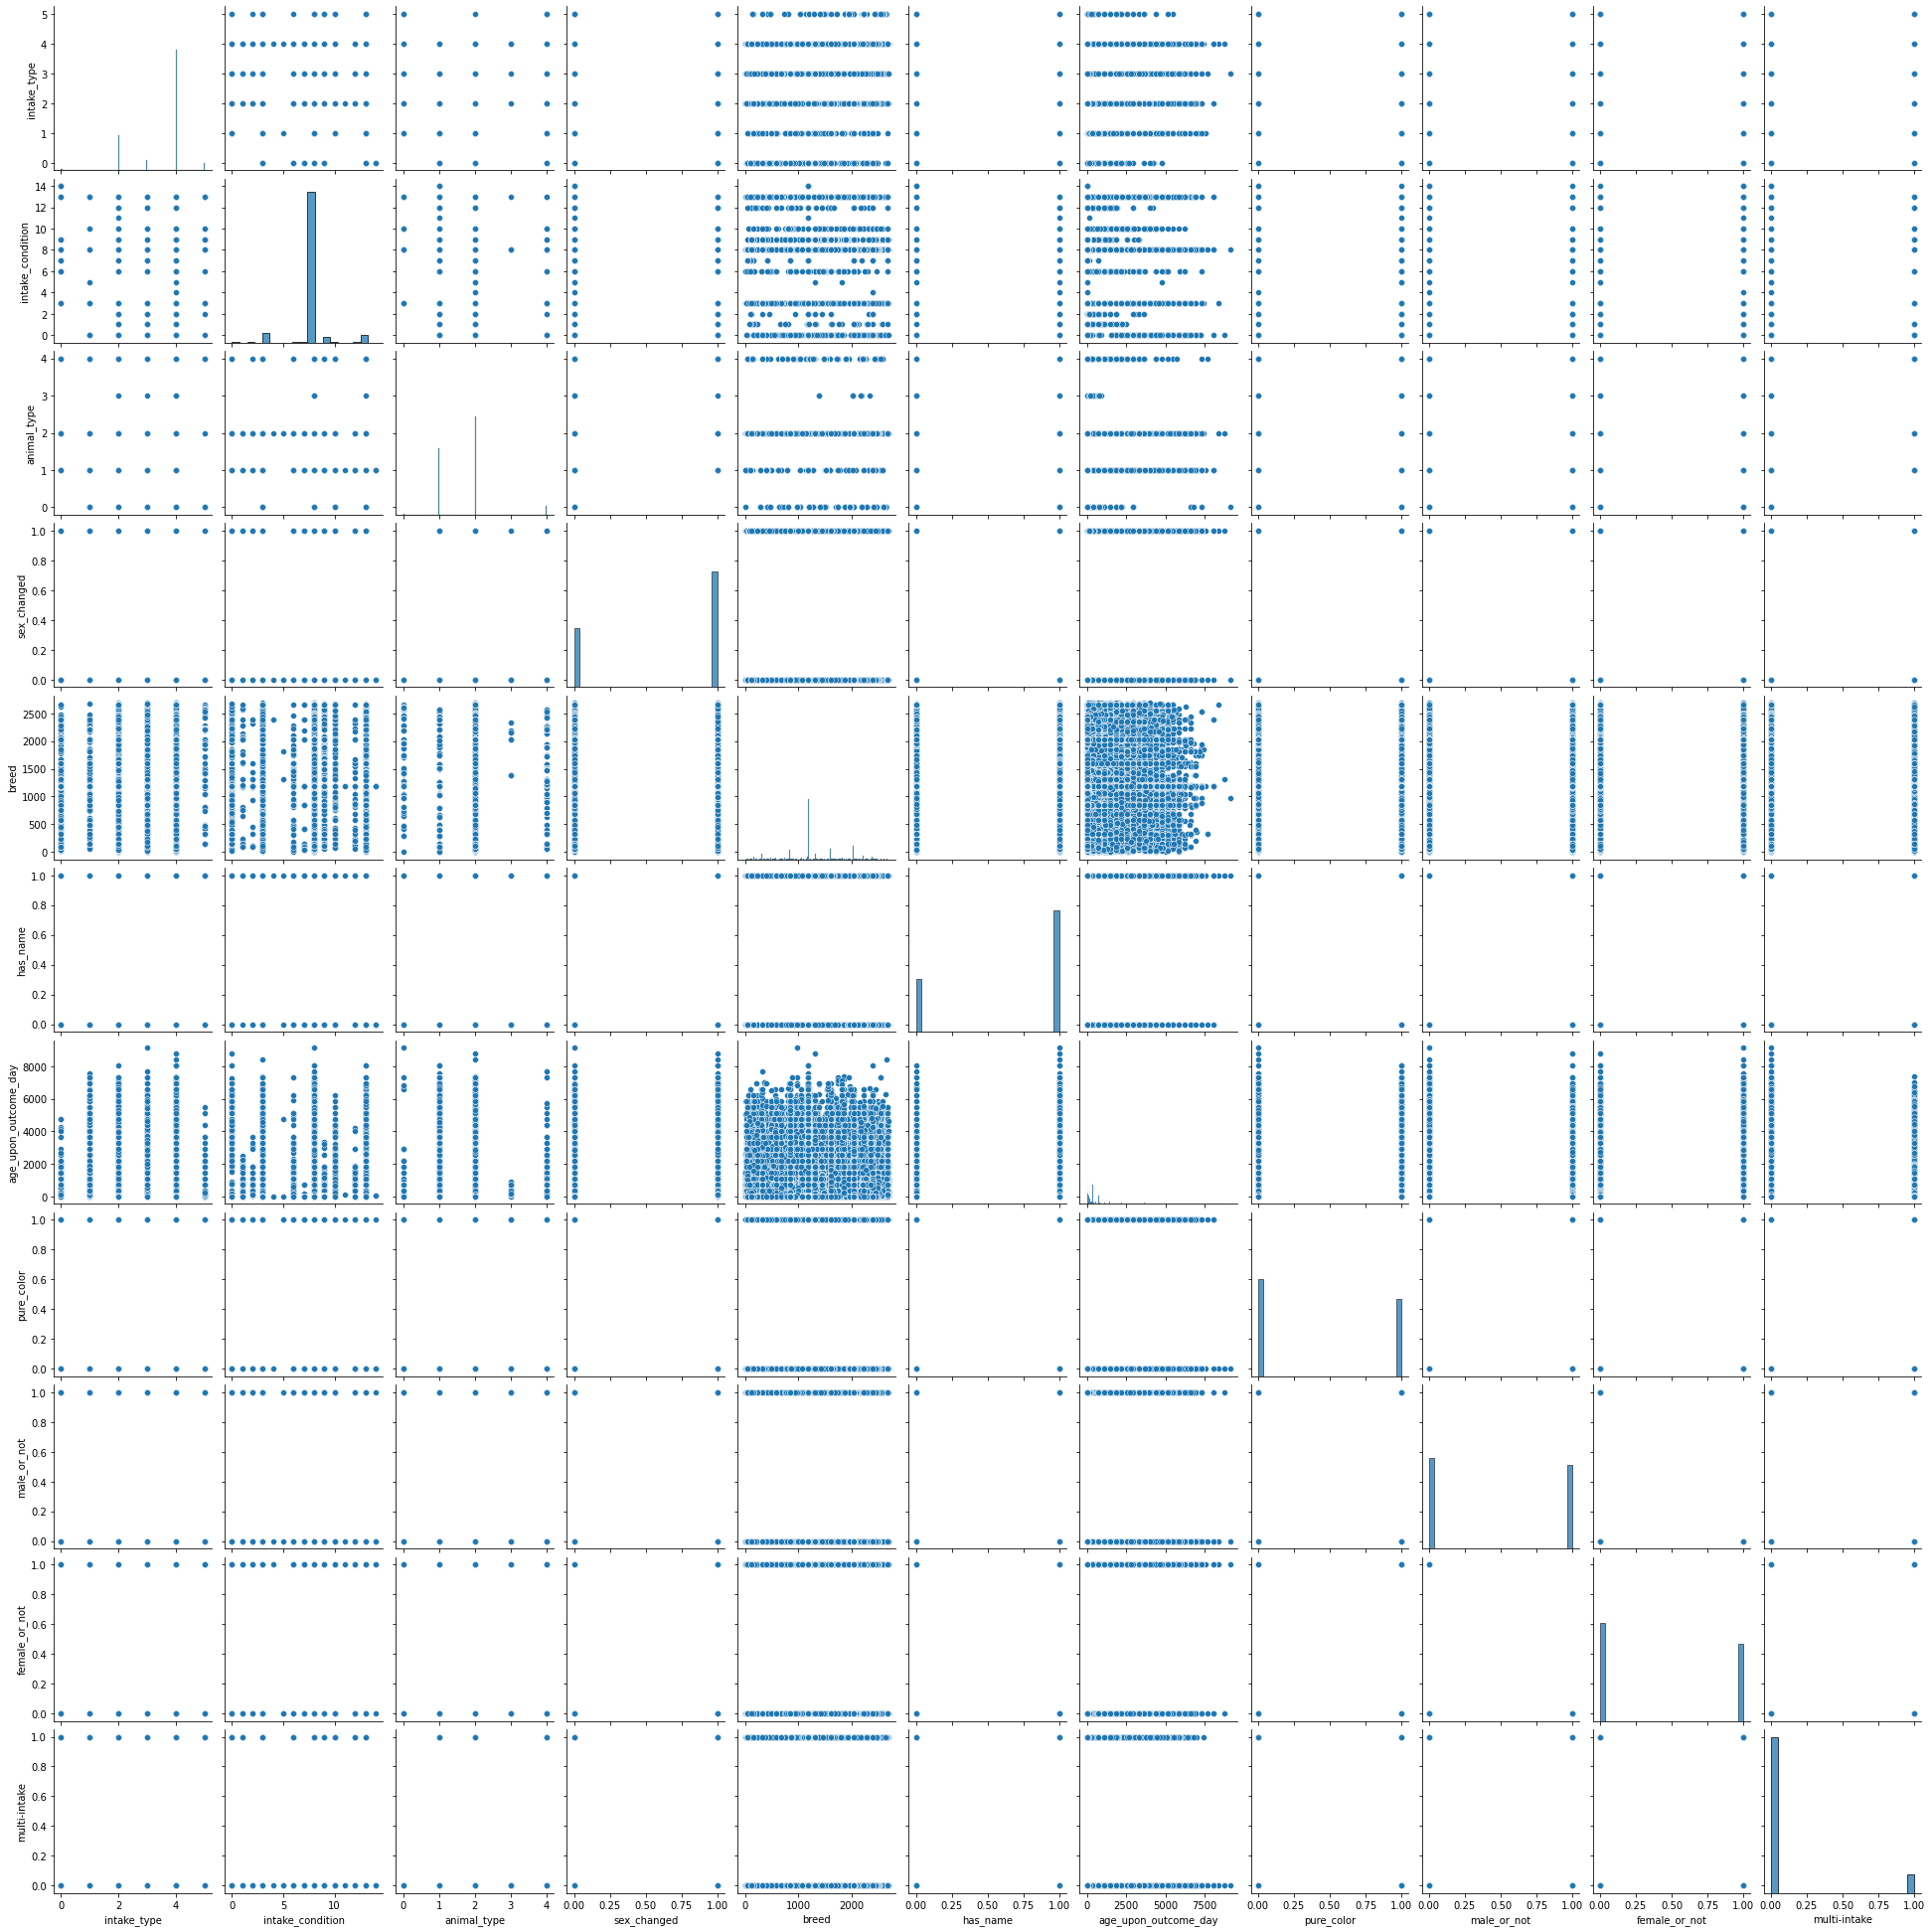

In [ ]:
# show relationships within features

sns.pairplot(data)

In [ ]:
data.head()

,intake_type,intake_condition,animal_type,sex_changed,breed,has_name,age_upon_outcome_day,pure_color,male_or_not,female_or_not,multi-intake
0,3,8,2,1.0,2460,1.0,2434.0,0,1,0,0
1,3,8,2,1.0,2460,1.0,2721.0,0,1,0,1
2,4,8,2,0.0,2460,1.0,-1.0,0,1,0,1
3,2,8,2,1.0,1041,1.0,3657.0,0,1,0,0
4,3,3,2,1.0,2338,1.0,5875.0,0,1,0,0


In [ ]:
label.head()

,adoption
0,0
1,0
2,0
3,0
4,0


In [ ]:
x = data
y = label

In [ ]:
# Split into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
# print(y_train[:5])

## Model Training

In [ ]:
# Train and fit in Logistic Regression model
LR = LogisticRegression(penalty='l2', multi_class='ovr', solver='newton-cg', max_iter=100).fit(x_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Predict on test dataset
y_pred_prob = LR.predict_proba(x_test)
print(x_test.shape, y_pred_prob.shape)
y_pred = LR.predict(x_test)
print(set(y_pred))
# print([outcome_type[i] for i in set(y_pred)])

(39753, 11) (39753, 2)
{0, 1}


In [ ]:
# Gradient Boosting
gbc = GradientBoostingClassifier(n_estimators=500, learning_rate=0.5, max_depth=1, random_state=0).fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# # Predict on test dataset
# y_pred_prob = gbc.predict_proba(x_test)
# print(x_test.shape, y_pred_prob.shape)
# y_pred = gbc.predict(x_test)
# print(set(y_pred))
# print([outcome_type[i] for i in set(y_pred)])
# score = gbc.score(x_test, y_test)
# print(score)

In [ ]:
# # standardization of variables
# y_pred = preprocessing.scale(y_pred)
# print(y_pred)

In [ ]:
# Metrics Evaluation
accuracy = metrics.accuracy_score(y_test, y_pred)
macro_f1 = metrics.f1_score(y_test, y_pred, average='macro')
micro_f1 = metrics.f1_score(y_test, y_pred, average='micro')
weighted_f1 = metrics.f1_score(y_test, y_pred, average='weighted')
macro_precision = metrics.precision_score(y_test, y_pred, average='macro')
micro_precision = metrics.precision_score(y_test, y_pred, average='micro')
weighted_precision = metrics.precision_score(y_test, y_pred, average='weighted')
print("Accuracy: ",  round(accuracy,4), "\n Macro F1 Score: ", round(macro_f1,4), "\n Macro Precision Score: ", round(macro_precision,4))

Accuracy:  0.7767 
 Macro F1 Score:  0.7767 
 Macro Precision Score:  0.7842


In [ ]:
# model evaluation process
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores using cross validation
n_scores = cross_val_score(LR, x, y, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

In [ ]:
# Tree Model
tree_model = DecisionTreeClassifier(max_depth=9)
tree_model.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=9)

In [ ]:
y_pred = tree_model.predict(x_test)
y_pred

array([1, 1, 0, ..., 1, 1, 1])

In [ ]:
correct = 0
for i in range(len(y_pred)):
  if y_pred[i] == int(y_test.iloc[i,:]):
    correct += 1

print(correct / len(y_pred))

0.8278872034814982


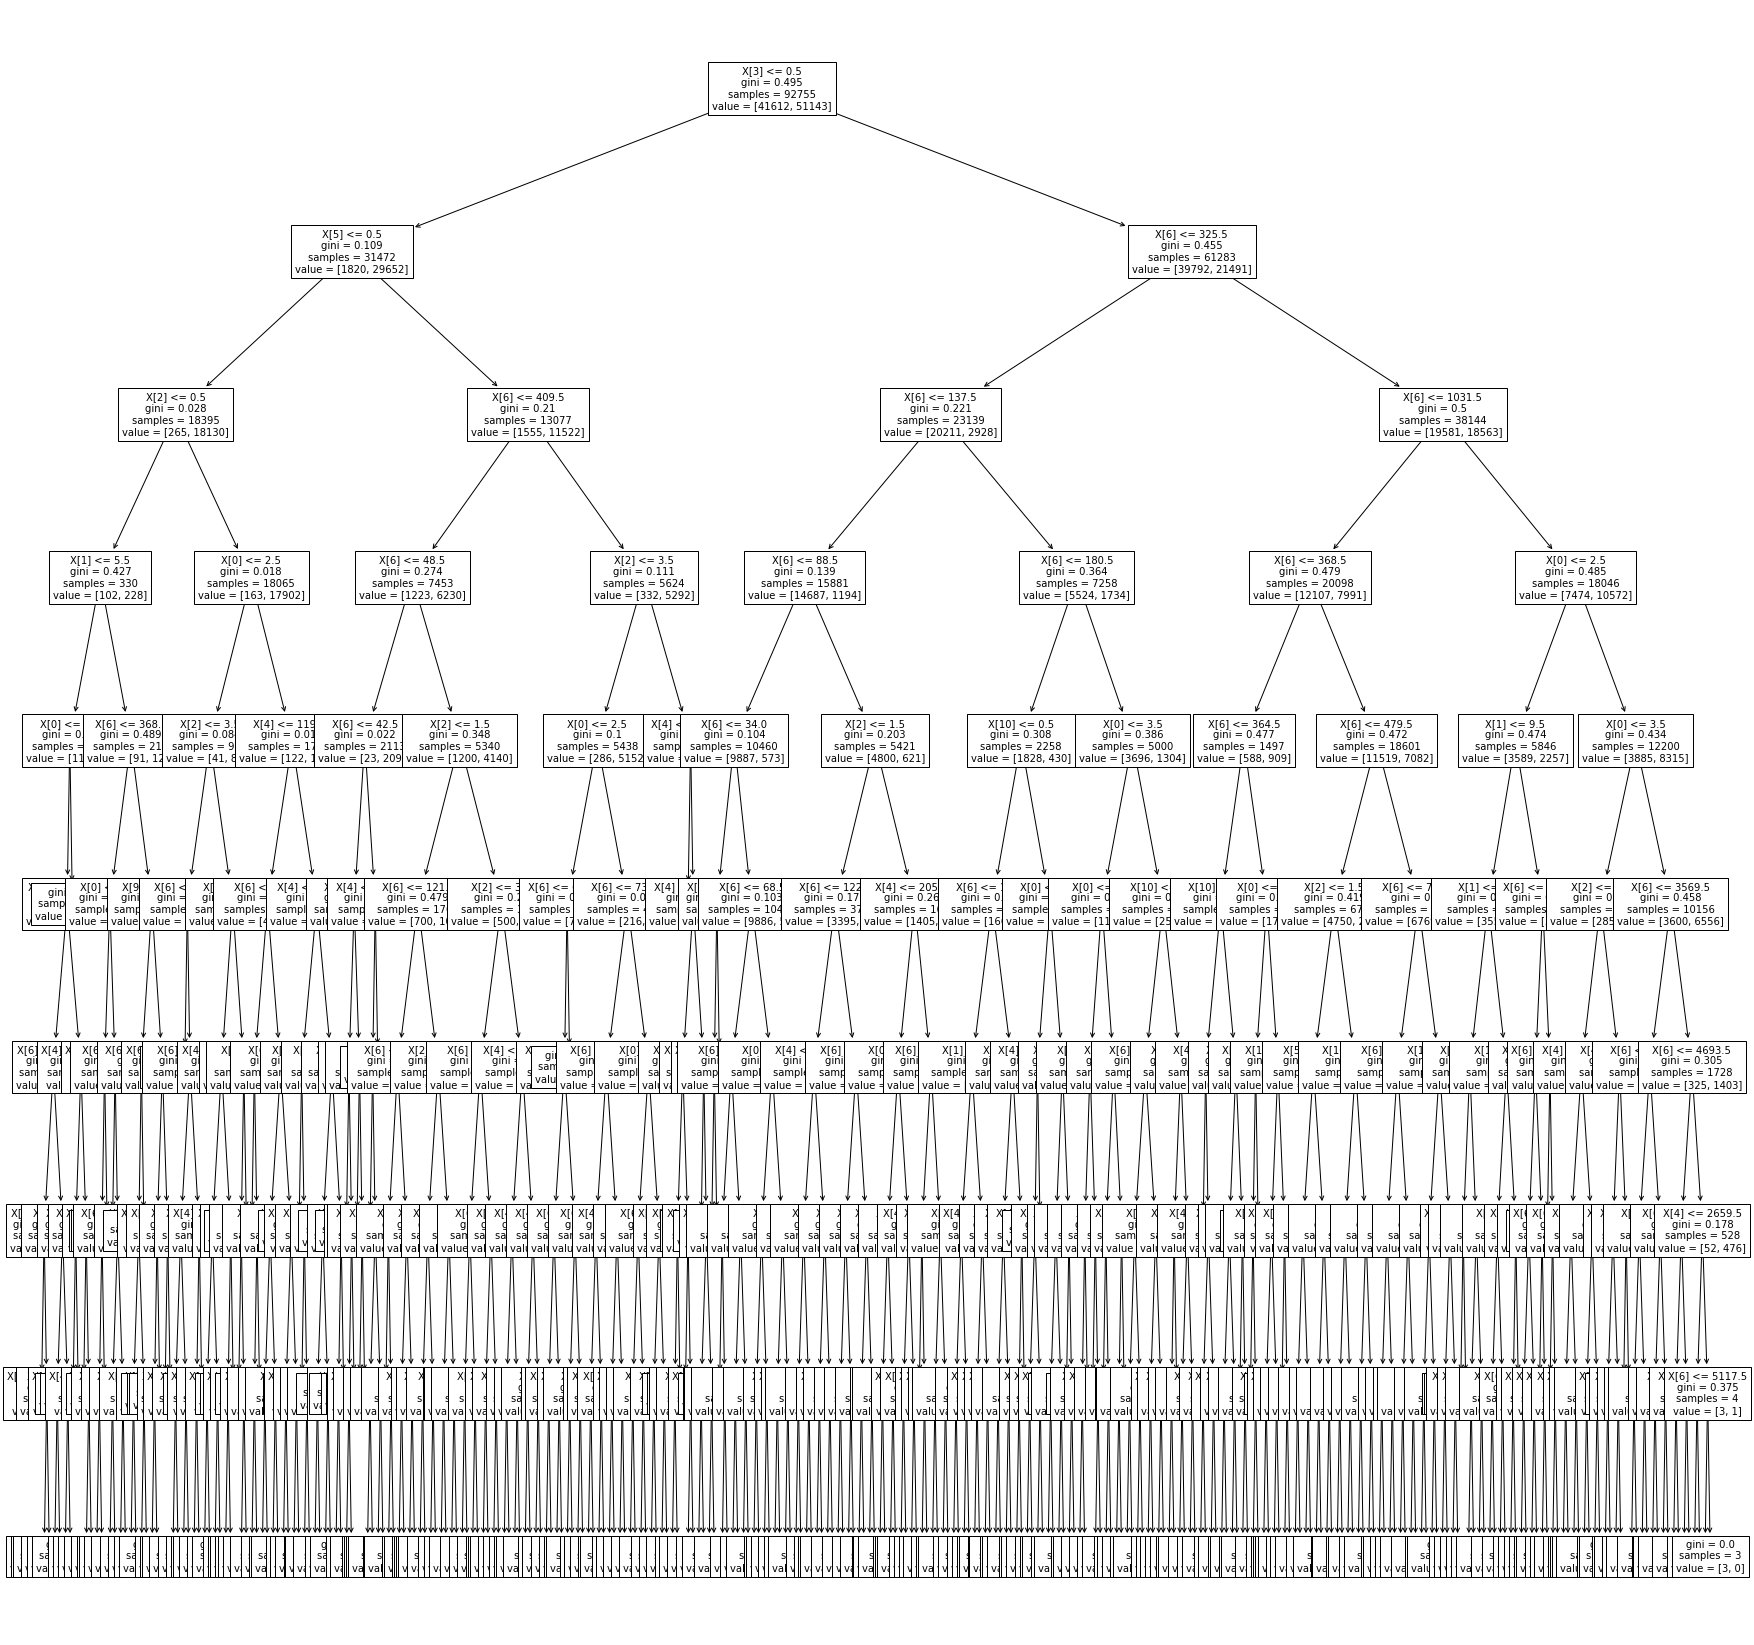

In [ ]:
plt.figure(figsize=(30, 30))  # set plot size (denoted in inches)
tree.plot_tree(tree_model.fit(x_train, y_train), fontsize=10)
plt.show()

In [ ]:
# Saving model to current directory
# Pickle serializes objects so they can be saved to a file, and loaded in a program again later on.
import pickle
pickle.dump(tree_model, open('model.pkl','wb'))

##Metric Plots for best model

ROC AUC  Graph

No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.906
Gradient Boost: ROC AUC=0.903
Logistic: ROC AUC=0.859


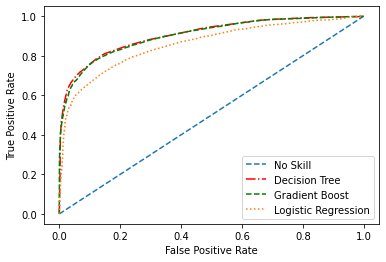

In [ ]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
probs_tree = tree_model.predict_proba(x_test)
probs_lr = LR.predict_proba(x_test)
probs_gbc = gbc.predict_proba(x_test)
# keep probabilities for the positive outcome only
probs_tree = probs_tree[:, 1]
probs_lr = probs_lr[:, 1]
probs_gbc = probs_gbc[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
tree_auc = roc_auc_score(y_test, probs_tree)
gbc_auc = roc_auc_score(y_test, probs_gbc)
lr_auc = roc_auc_score(y_test, probs_lr)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Decision Tree: ROC AUC=%.3f' % (tree_auc))
print('Gradient Boost: ROC AUC=%.3f' % (gbc_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
tree_fpr, tree_tpr, _ = roc_curve(y_test, probs_tree)
gbc_fpr, gbc_tpr, _ = roc_curve(y_test, probs_gbc)
lr_fpr, lr_tpr, _ = roc_curve(y_test, probs_lr)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='dashed', label='No Skill')
plt.plot(tree_fpr, tree_tpr, linestyle='dashdot', color = 'red', label='Decision Tree')
plt.plot(gbc_fpr, gbc_tpr, linestyle='dashed', color = 'green', label='Gradient Boost')
plt.plot(lr_fpr, lr_tpr, linestyle='dotted', label='Logistic Regression')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [ ]:
# convert data to json
no_skill = {'x': ns_fpr, 'y': ns_tpr}
ns = pd.DataFrame(data=no_skill)
ns = ns.to_json(orient="records")
parsed = json.loads(DT)
no_skill = json.dumps(parsed, indent=4)
jsonFile = open("no_skill_ROC.json", "w")
jsonFile.write(no_skill)
jsonFile.close()

decision_tree = {'x': tree_fpr, 'y': tree_tpr}
DT = pd.DataFrame(data=decision_tree)
DT = DT.to_json(orient="records")
parsed = json.loads(DT)
decision_tree = json.dumps(parsed, indent=4)
jsonFile = open("decision_tree_ROC.json", "w")
jsonFile.write(decision_tree)
jsonFile.close() 

gradient_boost = {'x': gbc_fpr, 'y': gbc_tpr}
gbc = pd.DataFrame(data=gradient_boost)
gbc = gbc.to_json(orient="records")
parsed = json.loads(gbc)
gradient_boost = json.dumps(parsed, indent=4)
jsonFile = open("gradient_boost_ROC.json", "w")
jsonFile.write(gradient_boost)
jsonFile.close() 

logistic_regression = {'x': lr_fpr, 'y': lr_tpr}
lr = pd.DataFrame(data=logistic_regression)
lr = lr.to_json(orient="records")
parsed = json.loads(lr)
logistic_regression = json.dumps(parsed, indent=4)
jsonFile = open("logistic_regression_ROC.json", "w")
jsonFile.write(logistic_regression)
jsonFile.close()


Accuracy for validation from different models

Decision Tree Accuracy Score:  0.8281 
Gradient Boosting Accuracy Score:  0.8232 
Logistic Regression Accuracy Score:  0.7767
Decision Tree Precision Score:  0.8779 
Gradient Boosting Precision Score:  0.8639 
Logistic Regression Precision Score:  0.8642


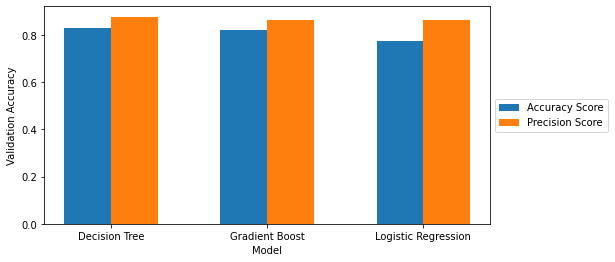

In [ ]:
# get predict
y_pred_tree = tree_model.predict(x_test)
y_pred_lr = LR.predict(x_test)
y_pred_gbc = gbc.predict(x_test)
# Accuracy score
accuracy_tree = metrics.accuracy_score(y_test, y_pred_tree)
accuracy_lr = metrics.accuracy_score(y_test, y_pred_lr)
accuracy_gbc = metrics.accuracy_score(y_test, y_pred_gbc)
precision_tree = metrics.precision_score(y_test, y_pred_tree)
precision_lr = metrics.precision_score(y_test, y_pred_lr)
precision_gbc = metrics.precision_score(y_test, y_pred_gbc)
# Print out result
print('Decision Tree Accuracy Score: ',  round(accuracy_tree,4), '\n'
      'Gradient Boosting Accuracy Score: ',  round(accuracy_gbc,4), '\n'
      'Logistic Regression Accuracy Score: ',  round(accuracy_lr,4))
print('Decision Tree Precision Score: ',  round(precision_tree,4), '\n'
      'Gradient Boosting Precision Score: ',  round(precision_gbc,4), '\n'
      'Logistic Regression Precision Score: ',  round(precision_lr,4))
# Plot
xaxis = ['Decision Tree', 'Gradient Boost', 'Logistic Regression']
yaxis = [[accuracy_tree, accuracy_gbc, accuracy_lr],
         [precision_tree, precision_lr, precision_gbc]]
ind = np.arange(3)
fig = plt.figure(figsize=(8,4))
width = 0.3
plt.bar(ind, yaxis[0] , width, label='Accuracy Score')
plt.bar(ind + width, yaxis[1], width, label='Precision Score')
plt.xlabel('Model')
plt.ylabel('Validation Accuracy')
plt.xticks(ind + width / 2, xaxis)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()